In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import nibabel as nb
from nipype.interfaces import fsl, ants
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
import scipy.stats as stats
from brainsmash.mapgen.sampled import Sampled
from brainsmash.mapgen.eval import sampled_fit
import pandas as pd

In [3]:
data_dir = '/home/julia/data/gradients/'

### Mask T1w and T2w images

In [4]:
waxholm_mask = np.asanyarray(nb.load(data_dir + 't1w_t2w/WHS_0_6_1_Labels_downsample2.nii.gz').dataobj)
waxholm_mask[waxholm_mask!=0]=1

In [5]:
t1w = np.asanyarray(nb.load(data_dir + 't1w_t2w/N4_canon_T1_r_downsample2.nii.gz').dataobj)
t2w = np.asanyarray(nb.load(data_dir + 't1w_t2w/N4_CT2Warped2T1_downsample2.nii.gz').dataobj)
t1w[waxholm_mask==0]=0
t2w[waxholm_mask==0]=0

### Flip Waxholm to Allen orientation for registration

In [6]:
allen = np.array(nb.load(data_dir + 'allen_atlas/template.nii.gz').dataobj)

In [7]:
def waxholm2allen(data):
    data = np.swapaxes(np.swapaxes(data, 0,2), 0,1)
    data = np.flip(np.flip(data,0),1)
    return data

In [8]:
t1w = waxholm2allen(t1w)
t2w = waxholm2allen(t2w)

(-0.5, 255.5, 511.5, -0.5)

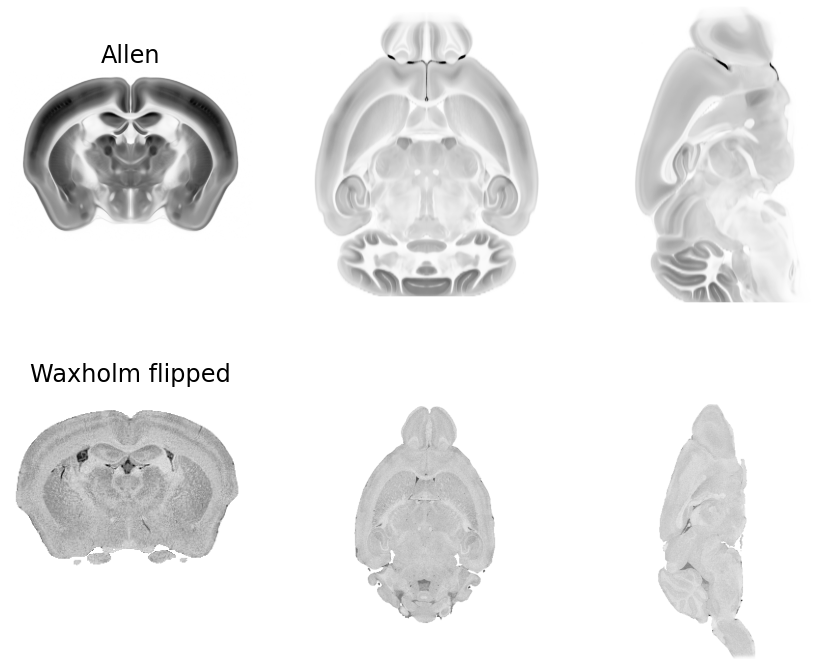

In [9]:
sns.set_context('poster')
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2,3,1)
plt.imshow(allen[250, :,:], 'Greys')
plt.title('Allen')
plt.axis('off')
fig.add_subplot(2,3,2)
plt.imshow(allen[:, 150,:], 'Greys')
plt.axis('off')
fig.add_subplot(2,3,3)
plt.imshow(allen[:, :,250], 'Greys')
plt.axis('off')

fig.add_subplot(2,3,4)
plt.imshow(t1w[250, :,:], 'Greys')
plt.axis('off')
plt.title('Waxholm flipped')
fig.add_subplot(2,3,5)
plt.imshow(t1w[:, 100,:], 'Greys')
plt.axis('off')
fig.add_subplot(2,3,6)
plt.imshow(t1w[:, :,120], 'Greys')
plt.axis('off')

In [10]:
aff = np.eye(4)*0.043
aff[3,3] = 1
nb.save(nb.Nifti1Image(t1w, aff), data_dir + 't1w_t2w/t1w_masked.nii.gz')
nb.save(nb.Nifti1Image(t2w, aff), data_dir + 't1w_t2w/t2w_masked.nii.gz')

### Register Waxholm to Allen space (cmd line)

### Resample to 200um

In [11]:
resamp = fsl.FLIRT(in_file=data_dir+'t1w_t2w/t1w2allen.nii.gz',
                   reference=data_dir+'allen_atlas/template_200um.nii.gz',
                   apply_isoxfm=0.2,
                   interp='spline',
                   out_file=data_dir+'t1w_t2w/t1w2allen_200um.nii.gz')
resamp.run()

In [12]:
resamp = fsl.FLIRT(in_file=data_dir+'t1w_t2w/t2w2allen.nii.gz',
                   reference=data_dir+'allen_atlas/template_200um.nii.gz',
                   apply_isoxfm=0.2,
                   interp='spline',
                   out_file=data_dir+'t1w_t2w/t2w2allen_200um.nii.gz')
resamp.run()

### Compute ratio and mask

In [5]:
template = np.asanyarray(nb.load(data_dir+'allen_atlas/template_200um.nii.gz').dataobj)
mask_img = nb.load(data_dir+'allen_atlas/cortex_mask_tight_200um.nii.gz')
aff = mask_img.affine
mask = np.asanyarray(mask_img.dataobj)
t1w = np.asanyarray(nb.load(data_dir+'t1w_t2w/t1w2allen_200um.nii.gz').dataobj)
t2w = np.asanyarray(nb.load(data_dir+'t1w_t2w/t2w2allen_200um.nii.gz').dataobj)

In [14]:
t1wt2w = t1w / t2w
t1wt2w[mask==0]=0
t1wt2w[np.isnan(t1wt2w)]=0
nb.save(nb.Nifti1Image(t1wt2w, aff), data_dir + 't1w_t2w/t1wt2w_200um_masked.nii.gz')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-0.5, 65.5, 39.5, -0.5)

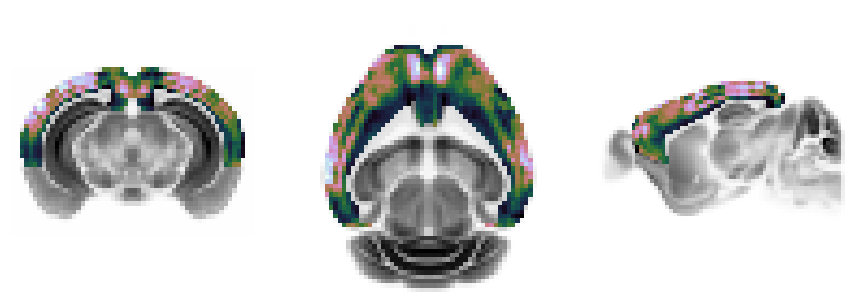

In [15]:
t1wt2w[mask==0]=np.nan

fig = plt.figure(figsize=(15,8))
fig.add_subplot(1,3,1)
plt.imshow(template[40,:,:], cmap='Greys')
plt.imshow(t1wt2w[40,:,:], cmap='cubehelix')
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(template[:,12,:], cmap='Greys')
plt.imshow(t1wt2w[:,12,:], cmap='cubehelix')
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(template[:,:,20].T, cmap='Greys')
plt.imshow(t1wt2w[:,:,20].T, cmap='cubehelix')
plt.axis('off')

### Correlate to Gradients

In [6]:
t1wt2w = np.array(nb.load(data_dir+"t1w_t2w/t1wt2w_200um_masked.nii.gz").dataobj)[mask==1]

In [7]:
gradients = np.load(data_dir + 'results/embedding/embed.npy')[:,:6]

Gradient 1: Spearman r=0.07, p=1.8016
Gradient 2: Spearman r=-0.17, p=0.0846
Gradient 3: Spearman r=0.19, p=0.0180
Gradient 4: Spearman r=-0.07, p=1.8526
Gradient 5: Spearman r=-0.13, p=0.4062
Gradient 6: Spearman r=0.09, p=1.1705


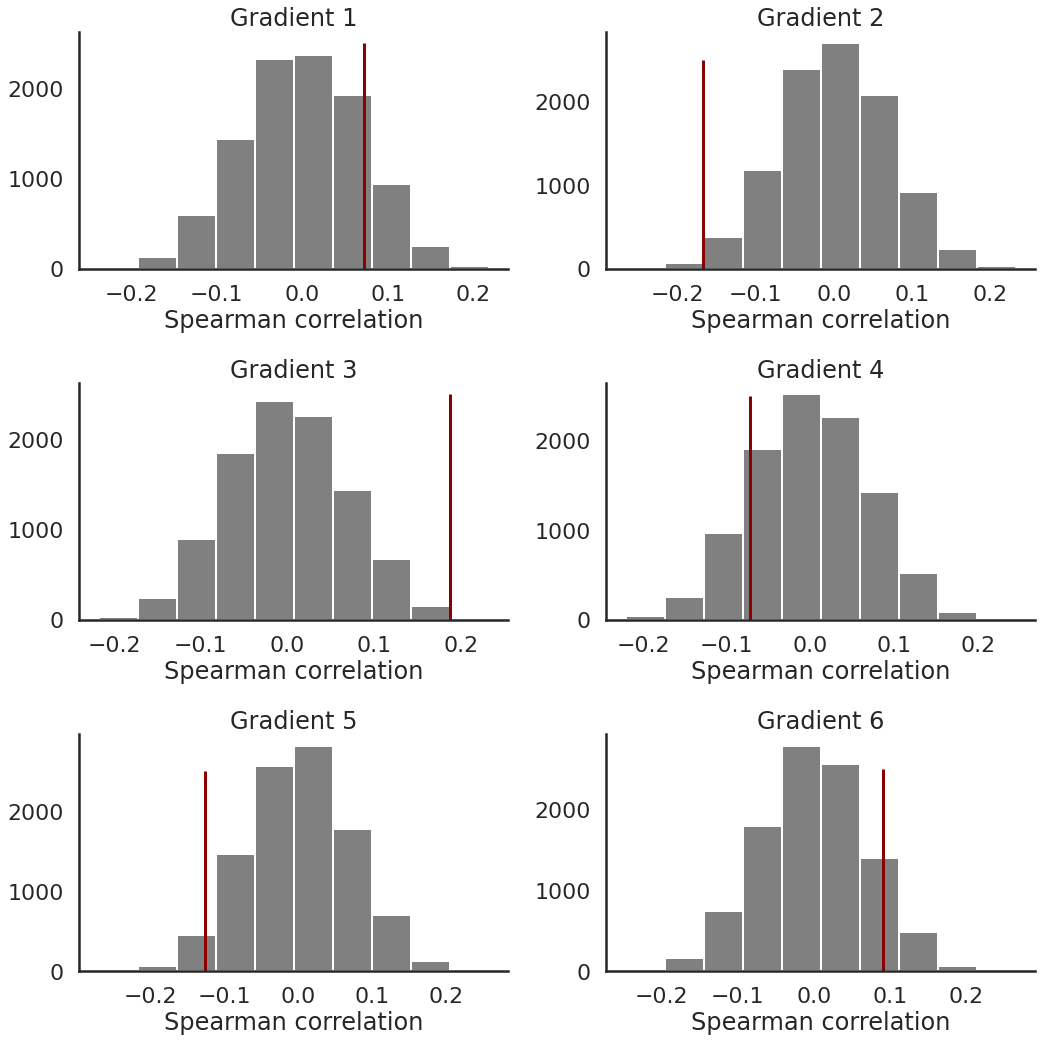

In [13]:
sns.set_style('white')
sns.set_context('poster')
fig = plt.figure(figsize=(15,15))

for g in range(6):
    rs = []
    surrogates = np.load(data_dir + 'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(g))
    for s in range(10000):
        r, _ = stats.spearmanr(surrogates[s,:], t1wt2w)
        rs.append(r)
    r, _ = stats.spearmanr(gradients[:,g], t1wt2w)
    p = np.where(np.abs(rs)>=np.abs(r))[0].shape[0] / (len(rs)+1) * 6
    print('Gradient {}: Spearman r={:.2f}, p={:.4f}'.format(g+1, r, p))
    
    fig.add_subplot(3,2,g+1)
    plt.hist(rs, color='grey', label='Surrogate maps')
    plt.vlines(r, 0,2500, color='darkred', label='Gradient {}'.format(g+1))
    plt.xlabel('Spearman correlation')
    plt.title('Gradient {}'.format(g+1))
    sns.despine()
plt.tight_layout()